# Image classification using transfer learning

- Detect presence of skin leision / sign of skin cancer based on  dermatoscopic images of pigmented lesions 
- This problem was taken from the following Kaggle challenge: 
    - https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000

- This notebook was inspired by the following tutorials:
    - https://www.kaggle.com/xinruizhuang/skin-lesion-classification-acc-90-pytorch
    - https://www.kaggle.com/kmader/dermatology-mnist-loading-and-processing


## A. Setup

### A.1 Get more ram on google colab

In [1]:
colab = True
setup = True
more_ram = True

In [2]:
# 1.  Get more ram
if colab and not more_ram:
    # code to crash colab and get more ram
    a = []
    while(1):
        a.append(1)

### A.2 Load libraries and variables


In [3]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 50)

if colab:
    # Mount google drive
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Activate GPU
import torch
from tqdm import tqdm
from glob import glob
from PIL import Image

### A.3 Fix randomness for reproducible results

In [5]:
# Fix random number for reproducible results
seed_value= 0

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

### A.4 Load dataset
- the dataset comes from Kaggle competition: 
https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000/notebooks

- Instructions for loading data from kaggle:
    - https://www.kaggle.com/general/74235

In [6]:
def get_data_path(local_path = "/Volumes/MoonSSD/GitJobPrep/Notebooks/examples/cancer_mnist/archive"):
    """
    Get dataset on local machine or colab
    - If working on local machine, path is set to specific path on local computer
    - If working on colab, import dataset from kaggle and get path to dataset loaded

    Inputs: 
    - local_path: path to dataset on local computer, defaults to str relevant for my computer
    """
    if colab:
        import os
        from google.colab import files
        files.upload()

        !pip install --upgrade --force-reinstall --no-deps kaggle
        ! mkdir -p ~/.kaggle
        ! cp kaggle.json ~/.kaggle/
        !ls ~/.kaggle
        !chmod 600 /root/.kaggle/kaggle.json
        !kaggle kernels list 
        ! kaggle datasets download -d kmader/skin-cancer-mnist-ham10000 --force

        # Unzip file downloaded
        import zipfile
        data_path = 'dataset'
        zip_ref = zipfile.ZipFile('skin-cancer-mnist-ham10000.zip', 'r')
        zip_ref.extractall(data_path)
        zip_ref.close()

        return data_path
    else:
        return local_path

### A.5 Process dataset into notebook

- Instructions followed from: https://www.kaggle.com/kmader/dermatology-mnist-loading-and-processing

In [7]:
if (colab and not setup) or not colab: 
    data_path = get_data_path()

else:
    data_path = "dataset"

In [8]:
from glob import glob
import skimage
from skimage.io import imread
import os
from PIL import Image

def get_data_frame(data_path: str, meta_data = 'HAM10000_metadata.csv', label_col = "cell_type_idx", sample = False):
    """
    Get dataframe of relevant information from specified data path

    Inputs:
    - path: path to files

    Output:
    - df:
        - leision id: unique ID for leision
        - image_id: unique ID for image
        - dx: abbrv to specify leision type
        - dx_type: long form specifying leision type
        - age: participant's age
        - sex: participant's gender
        - localization: location of leision on body
        - path: path to image
        - cell_type: type of cell on leision
        - cell_type_idx: categorical (label) for type of cell on leision (prediction label)
        - image: image file from path
    """

    # Obtain all file paths in folder
    image_paths = glob(os.path.join(data_path, '*', '*.jpg'))       # glob ('*.jpg') = find all files in path that end with .jpg

    # Obtain dictionary of image IDs (written as file name) and their corresponding file paths
        # keys = image id, values = path to image
    imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in image_paths}  # os.path.basename = return basename of path (/foo/bar = bar)

    # Dictionary that maps leision types abbrv with full names
    lesion_type_dict = {
        'nv': 'Melanocytic nevi',
        'mel': 'dermatofibroma',
        'bkl': 'Benign keratosis-like lesions ',
        'bcc': 'Basal cell carcinoma',
        'akiec': 'Actinic keratoses',
        'vasc': 'Vascular lesions',
        'df': 'Dermatofibroma'
    }

    # Obtain meta data
    df = pd.read_csv(os.path.join (data_path, meta_data))

    if sample:
        df = df.reindex(np.random.permutation(df.index))
        df = df.iloc[:50]

    # add path to image match image_id
    df["path"] = df["image_id"].map(imageid_path_dict)      # map column (pandas series) to output of dictionary
    df["cell_type"] = df["dx"].map(lesion_type_dict)

    # convert cell_type to categorical labels
    df[label_col] = pd.Categorical(df["cell_type"]).codes

    return df

In [9]:
df = get_data_frame(data_path, sample = False)
print(df.shape)
df.head() 

(10015, 10)


,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,dataset/ham10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,dataset/ham10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,dataset/ham10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,dataset/ham10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,dataset/HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2


## B. Data Exploration

### B.1 View original dataframe for signs of severe class imbalance

In [10]:
# Total counts, unique counts, most frequent, etc. 
df[['lesion_id', 'image_id', 'age', 'sex', 'localization', 'cell_type']].describe(exclude=[np.number])

,lesion_id,image_id,sex,localization,cell_type
count,10015,10015,10015,10015,10015
unique,7470,10015,3,15,7
top,HAM_0003789,ISIC_0033691,male,back,Melanocytic nevi
freq,6,1,5406,2192,6705


In [11]:
import matplotlib.pyplot as plt

def graph_distribution(df: pd.DataFrame, label_col = "cell_type_idx"):
    """
    Graph distribution of labels in dataset
    """
    # Graph occurence of label (cell_type)
    fig, ax1 = plt.subplots(figsize= (10, 5))
    df['cell_type_idx'].value_counts().plot(kind="bar", ax= ax1)      # value_counts = count of unique values

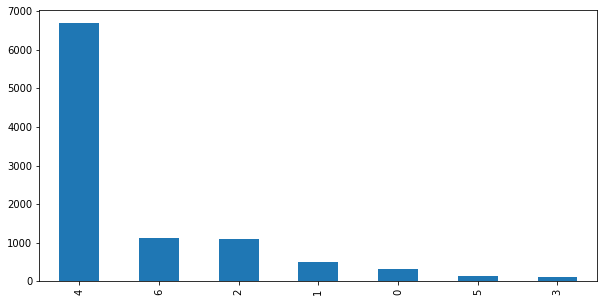

In [12]:
graph_distribution(df)

### B.2 Undersample dominating class

In [13]:
# number of classes of second most prevalent class
num_classes = len(df.loc[df["cell_type_idx"] == 6])

# cap all classes to num_classes
df = df.groupby('cell_type_idx').head(num_classes).reset_index(drop=True)
print(df.shape)
df.head()

(4423, 10)


,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,dataset/ham10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,dataset/ham10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,dataset/ham10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,dataset/ham10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,dataset/HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2


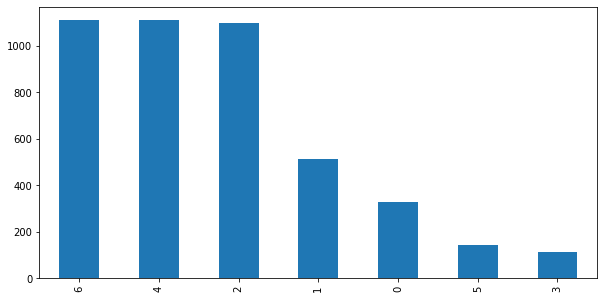

In [14]:
graph_distribution(df)

low_sample_classes = [1,0,5,3]

## C. Data Processing

### C.1 Remove duplicate images in the dataset

In [15]:
def remove_duplicates(df: pd.DataFrame, image_id_col = 'image_id', leision_id_col = 'lesion_id'):
    """
    Remove duplicates from dataset
    - duplicates are samples that have multiple images per leision ID
    - We want to obtain samples with leision IDs that have unique images

    Inputs:
    - df: skin cancer dataframe
    """
    # Get how many images are associated with each leison id
    df_unique = df[[image_id_col, leision_id_col]].groupby(leision_id_col).count()
    df_unique.reset_index(inplace=True)
    # Get lesions with unique images
    df_unique = df_unique.loc[df_unique[image_id_col] == 1]
    # Get list of unique lesion ids
    unique_ids = df_unique[leision_id_col].values
    df = df.loc[df[leision_id_col].isin(unique_ids)]

    return df

In [16]:
df = remove_duplicates(df)
print(df.shape)

(2212, 10)


### C.2 Data splits

- split data by image_id

In [17]:
from sklearn.model_selection import train_test_split

def get_data_splits(df: pd.DataFrame, test_size = np.double, id_col= "image_id", label_col = "cell_type_idx", data_col = 'path'):
    """
    Obtain stratified train and test data splits 
    Return train and test dataframes (with labels and images) and their corresponding labels 

    Inputs:
    - df: skin cancer dataframe
    - id_col: name of id col, defaults to "image_id"
    - label_col: name of label col, defaults to "cell_type_idx"
    - data_col: name of data col, defaults to "image_PIL"
    - test_size: size of test set, defaults to 0.33

    Outputs:
    - train_df: dataframe containins train data
    - test_df: dataframe containing test data
    - y_train: train labels
    - y_test: test labels
    """
    train_ids, test_ids, y_train, y_test = train_test_split(df[id_col].values, df[label_col].values, test_size=test_size, random_state=42)

    train_df = df[[id_col, label_col, data_col]].loc[df[id_col].isin(train_ids)]
    test_df = df[[id_col, label_col, data_col]].loc[df[id_col].isin(test_ids)]
    train_df = train_df.reset_index(drop= True)
    test_df = test_df.reset_index(drop= True)
    return train_df, test_df, y_train, y_test

In [18]:
train_df, test_df, y_train, y_test = get_data_splits(df, test_size = 0.1)

print("X train= ", train_df.shape)
print("X test= ", test_df.shape)

X train=  (1990, 3)
X test=  (222, 3)


## D. CNN model

### D.1 Define model 

Transfer learning in pytorch:
- https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
- finetuning: 
    - start with a pretrained model and update all of the model's parameters for the new task (ie. retrain the whole model)
- feature extraction:
    - start with a pretrained model and only update the final layer weights from which we derive predictions

Types of torchvision models:
- https://pytorch.org/docs/stable/torchvision/models.html

1) Resnet:
- https://missinglink.ai/guides/pytorch/pytorch-resnet-building-training-scaling-residual-networks-pytorch/
- CNN architecture
- proposed solution to the vanishing gradient problem 
    - normal neural networks are trained with back propagation (gradient descent to find optimal weights that minimize loss function) ==> repeated multiplication of derivatives make gradient infinitesimally small ==> additional layers don't improve performance, but decreases it
    - ResNet solves this with 'identity shortcut connections' (identical layers that initially skipped during training. they reuse activation functions from previous layers) = this reduces network to a few layers, which speeds learning. 
        - When the network trains again, the identical layers expand and help the network explore more of feature space 
        - this allows it to add much more layers without decrease in performance 

2) DenseNet:
- https://missinglink.ai/guides/pytorch/pytorch-resnet-building-training-scaling-residual-networks-pytorch/
- variation of resnet
- uses shortcut connections to connect all layers directly with each other
- input to each layer is feature maps for all earlier layers
- feature maps are joined using depth-concatenation = allowing the model to preserve all feature maps and increase variance of outputs ==> encourage feature reuse

3) VGG: 
- https://towardsdatascience.com/architecture-comparison-of-alexnet-vggnet-resnet-inception-densenet-beb8b116866d
- much deeper networks with much smaller filters
- pretty costly to compute because there are so many layers

4) Inception:
- https://towardsdatascience.com/architecture-comparison-of-alexnet-vggnet-resnet-inception-densenet-beb8b116866d
- https://cloud.google.com/tpu/docs/inception-v3-advanced
- overview of versions of inception network: https://towardsdatascience.com/a-simple-guide-to-the-versions-of-the-inception-network-7fc52b863202

- "we need to go deeper", google
Addresses the following problems:
- choosing the right kernel size for location of information is difficult because the size of item of interest varies widely 
    - larger kernels = preferred for inforamtion thhat is distributed globally
    - smaller kernels = preferred for inforamtion that is distributed locally
- very deep networks are prone to overfitting, and its difficult to pass gradient updates through entire network

Solution:
- have filters with multiple sizes that operate on the same level (ie. network becomes wider rather than deeper)
- made up of symmetric and asymmetric building blocks (eg. convolutions, average pooling, max pooling, dropouts, FC layers)
- works with factorizing convolutions (used to reduce number of connections and parameters to learn) ==> increase speed and gives good performance
- auxillary classifiers = added to prevent the vanishing gradient problem (ie. apply softmax to the outputs of two inception modules, compute auxiliary loss over the same labels)
    - adding batchnorm makes them act as regularizers
- label smoothing = regularizing component added to loss formula, prevent overfitting

In [19]:
def set_parameter_requires_grad(model, feature_extracting: bool):
    """
    Set parameter requires_grad in model
    - if the model does feature_extracting, requires_grad parameter is False
    - if the model does finetuning, requires_grad parameter is True

    Inputs:
    - model: pytorch model
    - feature_extracting: True if feature extracting, False if finetuning
    """
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [20]:
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
import torchvision
from torchvision import models

def create_model(model_name: str, num_classes: int, feature_extracting: bool, use_pretrained=True):
    """
    Creates various transfer learning models from torchvision
    Note: These models were defined by: https://www.kaggle.com/xinruizhuang/skin-lesion-classification-acc-90-pytorch
    and have been reimplemented for learning purposes

    Inputs:
    - model_name: name of transfer learning model to create
    - num_classes: number of classes to predict
    - feature_extracting: boolean to decide whether to create a feature extraction model (update only weights on final layer) or a finetuning model (update all weights for new task)
    Outputs:
    - model: initialized model
    - input_size: input size of model
    """
    model = None
    input_size = 0

    if model_name == "resnet":
        """ 
        Resnet
        """
        model = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model, feature_extracting)
        # number of features extracted from model
        num_ftrs = model.fc.in_features

        # final prediction layer
        model.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "densenet":
        """ Densenet121
        """
        model = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model, feature_extracting)

        # number of features extracted from model
        num_ftrs = model.classifier.in_features

        # final prediction layer
        model.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model, feature_extracting)

        # number of features extracted from model
        num_ftrs = model.classifier[6].in_features

        # final prediction layer
        model.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224 

    else:
        print("Invalid model name, exiting...")
        exit()
    return model, input_size

### D.2 Define torch dataset
- https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
- define transforms to apply to train (randomflips, random rotations, colorjitter, normalization etc) and test data (normalization)

In [21]:
import cv2

def compute_img_mean_std(df: pd.DataFrame, img_h = 224, img_w = 224, data_col = "path"):
    """
    Normalize image from 0-255 to 0-1
    Compute the mean and std of the three channels from the train dataset
    """
    imgs = []
    means, stdevs = [], []
    image_paths = df[data_col].values

    for i in tqdm(range(len(image_paths))):
        # resize image and append
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    imgs = imgs.astype(np.float32) / 255.   # normalize images

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()   # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means,stdevs

In [22]:
from torchvision import transforms

def get_transforms(train_df: pd.DataFrame, test_df: pd.DataFrame, input_size= 224):
    """
    Get transforms for the dataset
    - resize = to specified input size of model
    - RandomHorizontalFlip, RandomVerticalFlip, RandomRotation, ColorJitter = data augmentation
        - data augmentation is important to regularize your network and increase size of training set
        - here, we are using it to regularize
    - normalize = normalize images
    - totensor = convert np images to torch images

    Inputs:
    - train_df: train dataset
    - test_df: test dataset
    - input_size: input size required by model, defaults to 224

    Outputs:
    - augment_transform: basic transformation (ie. resizing, normalizing) with data augmentation 
    - basic_transform: basic transformation (ie. resizing, normalizing)
    """
    # Calculate mean and std based on train dataset
    norm_mean, norm_std = compute_img_mean_std(train_df)

    augment_transform = transforms.Compose([transforms.Resize((input_size,input_size)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                        transforms.ToTensor(), transforms.Normalize(norm_mean, norm_std)])

    basic_transform = transforms.Compose([transforms.Resize((input_size,input_size)), transforms.ToTensor(),
                                        transforms.Normalize(norm_mean, norm_std)])

    return augment_transform, basic_transform

### D.3 Define dataset with image transform

In [23]:
from torch.utils.data import DataLoader,Dataset

class HAM10000(Dataset):
    """
    Custom PyTorch dataset for HAM10000 dataset
    - apply data augmentation for classes with low class support
    """
    def __init__(self, df: pd.DataFrame, augment_transform=None, basic_transform=None, data_col = 'path', label_col = 'cell_type_idx'):
        self.df = df
        self.augment_transform = augment_transform
        self.basic_transform = basic_transform
        self.data_col = data_col
        self.label_col = label_col

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load data and get label
        X = Image.open(self.df[self.data_col][index])
        y = torch.tensor(int(self.df[self.label_col][index]))

        # if data needs to be augmented, apply augmentation transform
        if self.augment_transform:
            X = self.augment_transform(X)
        
        # if data does not need to be augmented (major class or test data), apply basic transform
        elif self.basic_transform:
            X = self.basic_transform(X)

        return X, y

### D.4 Model training 

In [24]:
class AverageMeter(object):
    """
    Function to calculate loss and accuracy during training
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [25]:
def train(train_loader, model, criterion, optimizer, epoch):
    """
    Function to train model

    Inputs:
    - train_loader: DataLoader for train dataset
    - model: model of choice
    - criterion: loss function for training
    - optimizer: optimizer of choice for the training
    - epoch: current epoch number

    Outputs:
    - train_loss.avg: average train loss
    - train_acc.avg: average train accuracy

    References: https://www.kaggle.com/xinruizhuang/skin-lesion-classification-acc-90-pytorch
    """
    total_loss_train, total_acc_train = [],[]

    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()

    curr_iter = (epoch - 1) * len(train_loader)

    for i, data in enumerate(train_loader):
        # get image and labels from dataloader instance
        images, labels = data
        N = images.size(0)  # batch size (ie. the neural network is updates after seeing N number of samples)
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        # Set gradients to zero before starting to do back propagation because pytorch accumulates the gradients on subsequent backward passes
        optimizer.zero_grad()
        # Get outputs from model given current image
        outputs = model(images)

        # calculate loss using loss function passed in
        loss = criterion(outputs, labels)

        # back propagation of loss
        loss.backward()
        # gradient descent to find weights that give min loss
        optimizer.step()

        # find predictions
        prediction = outputs.max(1, keepdim=True)[1]

        # update train acc and train loss
            # torch.view_as = view this tensor as same size as the other (ie. get labels as same size as prediction)
            # torch.eq = compute element-wise equality (ie. check if prediction and labels is the same)
            # .sum() = sum the output of the eq function = get count of number of times the model produced correct output
            # .item() = get actual value, not torch tensor
            # /N = average over number of images (in current batch)
        train_acc.update( prediction.eq(labels.view_as(prediction)).sum().item()/N )
        train_loss.update(loss.item())

        curr_iter += 1

        # For every 50 iteration (ie. datapoint trained) in current epoch
        if (i + 1) % 50 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)

    return train_loss.avg, train_acc.avg, total_loss_train, total_acc_train

In [26]:
def validate(val_loader, model, criterion, optimizer, epoch):
    """
    Validate trained model and obtain average loss and accuracy

    Inputs:
    - test_loader: DataLoader for test dataset
    - model: model of choice
    - criterion: loss function for training
    - optimizer: optimizer of choice for the training
    - epoch: current epoch number

    Outputs:
    - val_loss.avg: average val loss
    - val_acc.avg: average val accuracy

    References: https://www.kaggle.com/xinruizhuang/skin-lesion-classification-acc-90-pytorch
    """

    model.eval()    # notify all layers that we are in evaluation mode (ie. batchnorm or dropout layers will work in eval mode)
    val_loss = AverageMeter()
    val_acc = AverageMeter()

    # deactivates autograd engine (ie. reduce memory usage and speed up computations)
        # backprop is disabled
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            # get output scores from model
            outputs = model(images)
            # get label with max prediction score
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
            val_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

## E. Model Training and evaluating


### E.1 Tune model weights based on train and validation dataset

Addressing class imbalance:
- WeightedRandomSampler is used to ensure that each batch sees a proportional number of all classes.
- Data is augmented for classes with low sample sizes (pytorch transforms)


In [27]:
def run_train_validation(model, train_loader, val_loader, criterion, optimizer, epoch_num = 20):
    """
    Run training and validation
    Inputs:
    - train_loader: DataLoader for validation dataset
    - test_loader: DataLoader for test dataset
    - model: model of choice
    - criterion: loss function for training
    - optimizer: optimizer of choice for the training
    - epoch_num: number of epochs to train

    Outputs:
    - total_loss_val: array of total loss in validation per epoch
    - total_acc_val: array of total calculation in validation per epoch

    References: https://www.kaggle.com/xinruizhuang/skin-lesion-classification-acc-90-pytorch
    """

    best_val_acc = 0
    total_loss_val, total_acc_val = [],[]

    for epoch in range(1, epoch_num + 1 ):
        print("epoch: ", epoch, "/" , epoch_num)

        loss_train, acc_train, total_loss_train, total_acc_train = train(train_loader, model, criterion, optimizer, epoch)
        loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
        total_loss_val.append(loss_val)
        total_acc_val.append(acc_val)
        if acc_val > best_val_acc:
            best_val_acc = acc_val
            print('*****************************************************')
            print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
            print('*****************************************************')
    
    return total_loss_val, total_acc_val, total_loss_train, total_acc_train 

In [28]:
from torch.utils.data import WeightedRandomSampler

# Define model
model_name = 'densenet'
num_classes = 7
feature_extracting = False    # False = finetuning, True = feature extraction 

model, input_size = create_model(model_name=model_name, num_classes=num_classes, feature_extracting=feature_extracting, use_pretrained=True)
device = torch.device('cuda:0')
model = model.to(device)

augment_transform, basic_transform = get_transforms(train_df=train_df, test_df=test_df, input_size=input_size)

100%|██████████| 1990/1990 [00:21<00:00, 93.17it/s] 


normMean = [0.7853635, 0.5307834, 0.5485232]
normStd = [0.13058408, 0.14806533, 0.16119444]


In [29]:
# # Apply weighted random sampler to address class imbalance
# count_df = train_df["cell_type_idx"].value_counts().rename_axis('class').reset_index(name='count').sort_values(by=["class"])
# class_sample_counts = count_df["count"].values
# train_targets = count_df["class"].values
# weights = 1. / torch.tensor(class_sample_counts, dtype=torch.float)
# samples_weights = torch.FloatTensor(weights[train_targets])
# sampler = WeightedRandomSampler(weights=samples_weights, num_samples=len(samples_weights), replacement=True)

train_loader = DataLoader(dataset=HAM10000(df=train_df, augment_transform=augment_transform), batch_size=16, shuffle=True, num_workers=4)
test_loader = DataLoader(dataset=HAM10000(df=test_df, basic_transform=basic_transform), batch_size=32, shuffle=True, num_workers=4)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)

In [30]:
# Train and evaluate model with train and validation set
total_loss_val, total_acc_val, total_loss_train, total_acc_train = run_train_validation(model=model, train_loader=train_loader, val_loader=test_loader, criterion=criterion, optimizer=optimizer)

epoch:  1 / 20
[epoch 1], [iter 50 / 125], [train loss 1.11129], [train acc 0.62375]
[epoch 1], [iter 100 / 125], [train loss 1.02110], [train acc 0.64938]
------------------------------------------------------------
[epoch 1], [val loss 2.27501], [val acc 0.63601]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 2.27501], [val acc 0.63601]
*****************************************************
epoch:  2 / 20
[epoch 2], [iter 50 / 125], [train loss 0.87389], [train acc 0.67625]
[epoch 2], [iter 100 / 125], [train loss 0.85721], [train acc 0.69125]
------------------------------------------------------------
[epoch 2], [val loss 0.93051], [val acc 0.69732]
------------------------------------------------------------
*****************************************************
best record: [epoch 2], [val loss 0.93051], [val acc 0.69732]
*****************************************************
epoch:

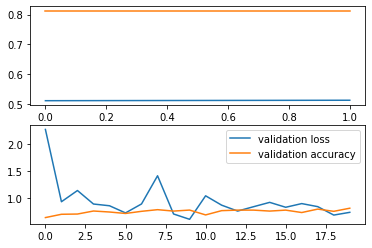

In [31]:
import matplotlib.pyplot as plt

# Plot train / test loss and accuracy
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
plt.legend()
plt.show()

### E.2 Evaluate data on test dataset

In [32]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [33]:
from sklearn.metrics import confusion_matrix
import itertools

def evaluate_model(model, test_loader, plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']):
    """
    Evaluate model on the test dataset

    Inputs:
    - model: trained model
    - test_loader: Dataloader for test dataset
    - plot_labels: plot labels corresponding to class labels, default to ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
    """
    model.eval()
    y_label = []
    y_predict = []
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            images, labels = data
            N = images.size(0)
            images = Variable(images).to(device)
            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]
            y_label.extend(labels.cpu().numpy())
            y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

    # compute the confusion matrix
    confusion_mtx = confusion_matrix(y_label, y_predict)
    # plot the confusion matrix
    
    plot_confusion_matrix(confusion_mtx, plot_labels)

    return y_label, y_predict

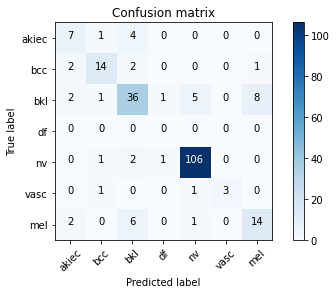

In [34]:
# evaluate model on test data
y_label, y_predict = evaluate_model(model= model, test_loader = test_loader)

### D.3 Classification report

In [35]:
from sklearn.metrics import classification_report
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']

report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.54      0.58      0.56        12
         bcc       0.78      0.74      0.76        19
         bkl       0.72      0.68      0.70        53
          df       0.00      0.00      0.00         0
          nv       0.94      0.96      0.95       110
        vasc       1.00      0.60      0.75         5
         mel       0.61      0.61      0.61        23

    accuracy                           0.81       222
   macro avg       0.65      0.60      0.62       222
weighted avg       0.82      0.81      0.81       222



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
